In [ ]:
import pandas as pd
import numpy as np
import tensorflow
import datetime as dt

In [ ]:
data = pd.read_csv(r'/content/TrainData30_03_2022.csv')
data.dropna(subset=['clean_text'],inplace=True)
data.drop(data[data.label == 0].index, inplace=True)

In [ ]:
X = pd.DataFrame(data['clean_text'])


In [ ]:
y = data[['label']]
y

,label
0,1
1,-1
2,-1
3,-1
4,1
...,...
2783,1
2784,1
2785,1
2786,-1


In [ ]:
y.value_counts()

label
 1       1416
-1       1327
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y = enc.fit_transform(y).toarray()

In [ ]:
tweets = X.clean_text.values


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(tweets)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
encoded_docs = tokenizer.texts_to_sequences(tweets)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(padded_sequence,Y,random_state = 0)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from keras.layers import Embedding

np.random.seed(4)
tensorflow.compat.v1.set_random_seed(4)

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           193760    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 210,462
Trainable params: 210,462
Non-trainable params: 0
________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights = True)


In [ ]:
history = model.fit(x_train,y_train, epochs=10, batch_size=32,validation_split=0.2, callbacks=[es])

Epoch 1/10
52/52 [==============================] - 44s 795ms/step - loss: 0.6859 - accuracy: 0.5629 - val_loss: 0.6720 - val_accuracy: 0.6529
Epoch 2/10
52/52 [==============================] - 40s 774ms/step - loss: 0.6247 - accuracy: 0.6760 - val_loss: 0.5869 - val_accuracy: 0.6699
Epoch 3/10
52/52 [==============================] - 41s 788ms/step - loss: 0.4917 - accuracy: 0.7660 - val_loss: 0.5107 - val_accuracy: 0.7451
Epoch 4/10
52/52 [==============================] - 40s 775ms/step - loss: 0.3539 - accuracy: 0.8596 - val_loss: 0.5186 - val_accuracy: 0.7500
Epoch 5/10
52/52 [==============================] - 40s 777ms/step - loss: 0.2819 - accuracy: 0.8906 - val_loss: 0.5579 - val_accuracy: 0.7379
Epoch 6/10
52/52 [==============================] - 41s 784ms/step - loss: 0.2236 - accuracy: 0.9149 - val_loss: 0.6194 - val_accuracy: 0.7257
Epoch 7/10
52/52 [==============================] - 41s 788ms/step - loss: 0.1697 - accuracy: 0.9380 - val_loss: 0.6798 - val_accuracy: 0.7112

In [ ]:
epochs = '10_32BS'

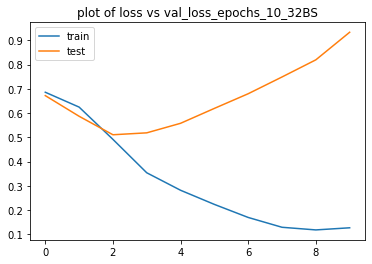

In [ ]:
from matplotlib import pyplot 
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title(f"plot of loss vs val_loss_epochs_{epochs}")
pyplot.show()

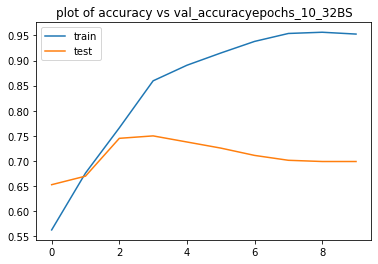

In [ ]:
from matplotlib import pyplot 
# plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title(f"plot of accuracy vs val_accuracyepochs_{epochs}")
pyplot.legend()
pyplot.show()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
cm = pd.DataFrame(index= [0,1],columns = [0,1])

for i in range(2):
    for j in range(2):
        cm[i][j] = 0
for i in range(len(y_pred)):
    cm[y_test[i].argmax()][y_pred[i].argmax()] +=1

true = cm[0][0]+cm[1][1]
false = cm[0][1] +cm[1][0]

accuracy = round((true/(false+true))*100,2)
print('Accuracy on test set = ' + str(accuracy))
cm

Accuracy on test set = 75.22


,0,1
0,249,75
1,95,267


In [ ]:
# Creating a useful name for our model
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_name = f'Model_Date_Time_{current_date_time_string}_epochs_{epochs}_Test_accuracy_{accuracy}.h5'
 
# Saving your Model
model.save(model_name)

In [ ]:
from keras.models import load_model
path = r'/content/Model_Date_Time_2022_03_30__10_14_27_epochs_5_32BS_Test_accuracy_74.64.h5'
model = load_model(path)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = model.predict(tw)
    print("Predicted label: ", prediction)
    if prediction[0][1] > prediction[0][0]:
        print('Positive Review')
        # return 1
    else:
        print('Negative Review')
        # return -1

test_sentence1 = "ukraine and russia are fighting"
predict_sentiment(test_sentence1)

test_sentence2 = "your product is bad"
predict_sentiment(test_sentence2)

test_sentence3 = "the customer service is extremely bad.called multiple times but still no response"
predict_sentiment(test_sentence3)

Predicted label:  [[0.14664142 0.84888047]]
Positive Review
Predicted label:  [[0.37128487 0.625641  ]]
Positive Review
Predicted label:  [[0.6996715  0.29743838]]
Negative Review
